# Access and load the Ichthys3D Seismic Survey
**Ben Lasscock, Enthought**

blasscock@enthought.com

The Ichthys3D Seismic data is being used as the training dataset for the [2020 FORCE Machine Learning Contest](https://xeek.ai/challenges/force-seismic/overview). This contest challenges participants to build and demonstrate machine learning models to predict the location of faults in seismic data. The dataset is a large (about 9.7 GB) SEGY file. This can take a while to download, and can be tricky to read into a format that is ready for machine learning.  

Many of us want to get the data easily and start hacking in tools we're familiar with, like Jupyter notebooks.
We believe that AI should be a tool we can all just use now. And that it should be just easy-as to go grab some data and experiment/learn. Geophysical data doesn't always fit the bill, so we made this notebook to help get started accessing and working with the data.

We have converted the Ichthys data volume to a Zarr array, and stored the data on the cloud. [Zarr](https://zarr.readthedocs.io/en/stable/index.html) is a Python package that provides a chunked, compressed, multi-dimensional array format.  Zarr arrays behave just like numpy arrays with the following benefits:
- **chunking** is used to break large multidimensional arrays in to smaller 'chunks' which can fit in to memory and provide faster access across array dimensions.  This is important for efficent parallel algorithms and data access.
- **compression** can be applied to array chunks to reduce the file size and improve transfer speeds.
- read and write data to a cloud storage system (eg [AWS S3](https://aws.amazon.com/free/storage/s3/)) just like the data was on your local file system
- you can access all of the data or part of it (like tiles). This is especially useful for machine learning on large datasets like seismic data.  

This notebook will demonstrate how to access the Ichthys 3D seismic data stored remotely on the cloud using Zarr. This will help you quickly get started exploring the data and experiment with building machine learning models to help interpret seismic data.  Please feel free to use this notebook and code for your own work.  Stay tuned to this repo for more notebooks that explore different aspects of this challenge. 

This data for Ichthys field data is provided Geoscience Australia under CC-BY 4.0.

Enjoy!

In [1]:
import matplotlib.pylab as plt
import numpy as np
import s3fs
import zarr

We have converted the Ichthys 3D data volume to a Zarr array and stored the data in a publicly accessible S3 bucket.  Note that we have compressed seismic amplitude data by converting to uint8 and using the [LZMA](https://en.wikipedia.org/wiki/Lempel%E2%80%93Ziv%E2%80%93Markov_chain_algorithm) algorithm.  The resulting Zarr data is 871.8 MB, compared to 9.7 GB for the original SEGY. 

In [2]:
# Location of the segy data in "ZArr format"
data_path='s3://zarr-depot/seismic/Ichthys3D/Ichthys 3D seismic for fault competition'

[S3Fs](https://s3fs.readthedocs.io/en/latest/) is a Pythonic file interface to S3.  It provides a convenient API for accessing data stored on S3.  These next few lines set up a connection to the remote seismic data, and create an object we can use to access the data.

In [3]:
# complicated stuff to access the data
client = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(
    root=data_path,
    s3=client, 
    check=False)
cache = zarr.LRUStoreCache(store, max_size=2**28)
# contains the seqy data for Ichthys3D
seismic_data = zarr.open_group(store=cache, mode='r')

That's it - now we can read the seismic data as if it was local.  The top level `segy_data` object is similar to a dictionary:

In [4]:
# list contents:
[i for i in seismic_data.keys()]

['coordinates',
 'indptr',
 'inline',
 'inlines',
 'map_inline_ends',
 'map_latitude',
 'map_longitude',
 'map_xline_ends',
 'trace_inlines',
 'trace_xlines',
 'xline',
 'xlines']

Let's inspect the inline and xline range:

In [5]:
print ("inline range : ", seismic_data['inlines'][:].min(), seismic_data['inlines'][:].max())
print ("xline range : ", seismic_data['xlines'][:].min(), seismic_data['xlines'][:].max())

inline range :  1001 3400
xline range :  2040 3040


The inline and xline data can be accessed using numpy-like array slicing.  Plot an example inline and xline:

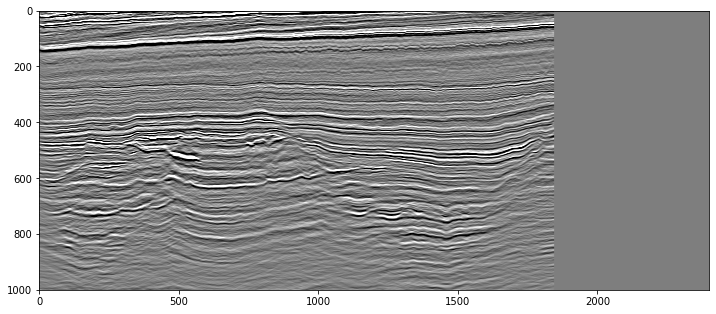

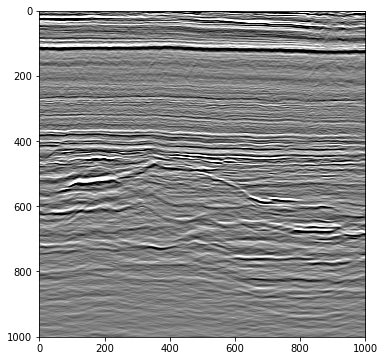

In [6]:
def clip(img):
    """Standardize contrast"""
    img = img - np.mean(img)
    return img/np.std(img)

# These are 8-bit unsigned ints
plt.figure(figsize=(12,6))
plt.imshow(clip(seismic_data['xline'][...,2222].T), cmap='gray', vmin=-2, vmax=2)
plt.show()

# slice data in the xline/inline direction
# Dead traces padded with 0's
plt.figure(figsize=(12,6))
plt.imshow(clip(seismic_data['inline'][...,1499].T), cmap='gray', vmin=-2, vmax=2)
plt.show()

Zarr takes care of caching results.  The first time data is accessed, it is transferred from the remote locations.  This result is cached so subsequent requests are much faster. 

In [7]:
from time import time
st = time()
x = seismic_data['xline'][...,2700]
print ("Elapsed time for first request: {}s".format(time() - st))

st = time()
x = seismic_data['xline'][...,2700]
print ("Elapsed time for second request: {}s".format(time() - st))

Elapsed time for first request: 0.2748708724975586s
Elapsed time for second request: 0.06660079956054688s


### Geospatial data
Some geospatial data is included in the segy data. The cell below creates a shapely polygon (latitude, longitude) bounding the survey.

In [8]:
from shapely.geometry import Polygon
# lat/lon bounding the survey
lati, longi = seismic_data['map_latitude'][:], seismic_data['map_longitude'][:]
points = list(zip(lati, longi))

### Map Plot

Let's make an interactive map plot of the seimic survey location using Leaflet.  We'll use the [`ipyleaflet`](https://github.com/jupyter-widgets/ipyleaflet) library.  This requires a bit of configuration, but you'll only have to do this one time. 

Stop your notebook, and from the terminal, run these commands in order: 

**pip install ipyleaflet**

**jupyter nbextension enable --py --sys-prefix ipyleaflet**

**jupyter notebook**

This will add dependencies and restart the notebook with the ability to 
render the map in the cell below.

If everything worked you should see the top-end of 'Straya, and a red box which is
the survey.

In [9]:
# for this to run, install ipyleaflet on command-line (see above)
from ipyleaflet import Map, Polygon, basemaps

m = Map(
    basemap=basemaps.Esri.WorldImagery,
    center=np.median(points, axis=0).tolist(),
    zoom=6
)

polygon = Polygon(
    locations=points,
    color="red",
    fill_color="green"
)

m.add_layer(polygon)
m

Map(center=[-13.949067585836929, 117.20016613893264], controls=(ZoomControl(options=['position', 'zoom_in_text…

The above code should render a map that looks like this:

![surveymap](images/map_survey.png)

Hopefully this has shown how Zarr can be used to provide a convenient way to store and access compressed seismic data on a cloud server.  Zarr is a great package for working with large scientific datasets (like seismic) on the cloud.  This notebook should help get started with the FORCE machine learning contest using Python and the data science tools you're familiar with.  

Feel free to get in touch if you have questions!

